In [1]:
import os
import sys
import time
import errno
import time
import timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline 

In [3]:
import tensorflow
import keras

In [4]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on tensorflow: v{}'.format(tensorflow.__version__))

Running on numpy: v1.21.5
Running on tensorflow: v2.8.0


In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
from matplotlib import rcParams

rcParams.update({'font.size': 15})

In [7]:
cwd = os.getcwd()
cwd

'/data/TimeSeriesForcasting'

In [8]:
# %load time_series_1.py
#!/usr/bin/env python2
"""
1-D Time-series prediction toolkit

@author: yuki
"""

'''
here are the various implemented algorithms, including their hyperparamter optimizations

''' 
from scipy.optimize import minimize

def AR_model(X,p,method=0,alpha=0.):
    """just fits the Least Squares AR model with alpha as regularization"""
    # X is datalength x dim
    # construct embedding matrix by shifting
    if method==0: # embedding matrix
        M = np.zeros(dtype='float',shape=(X.shape[0]-p, p, X.shape[1]))
        A = np.zeros(dtype='float',shape=(p, X.shape[1]))
        for dim in range(X.shape[1]):
            M[:,:,dim] = np.array([(X[k:k+p,dim])[::-1] for k in range(X.shape[0] - p)])
            A[:,dim] =  np.linalg.solve(np.dot(M[:,:,dim].T, M[:,:,dim])+np.eye(p)*alpha,
                                        np.dot(M[:,:,dim].T, X[p:,dim]))
    else:
        return 0 #implement at some point
    return A
    
def AR_rmse(theta,args):
    """returns RMSE of AR 1-step predictions for the validationset"""
    [alpha] = theta
    [p,X,n_valid,n_testper] = args
    for k in range(X.shape[0]-n_valid-n_testper,X.shape[0]-n_testper):
        X_train = X[0:k]
        X_valid = X[k:k+n_testper]
        pred = []
        X2 = X_train.copy()
        for j in range(n_testper):
            a = AR_model(X2[:,np.newaxis],int(p),alpha=alpha)
            yt = np.sum(a[:,0]* X2[-int(p):][::-1])
            X2 = np.hstack((X2,yt))
            pred.append(yt)
    return np.sqrt(np.sum((np.array(pred)-X_valid)**2)) # works only for n_testper =1

def predict_optimize_ARp(X_, n_predict, n_valid,n_testper,ps=range(1,20)):
    """this code optmizes for alpha for each lag-length p in ps 
        and returns a prediction using the best parameters of the validation set"""
    rmse=[]
    params=[]
    for p in ps:
        res = minimize(AR_rmse, 0.2, args=[p,X_[:-n_predict],n_valid,n_testper], method='Nelder-Mead',tol=1e-3,
                      options={'maxiter':50})
        params.append(res.x) 
        rmse.append(res.fun)
    # now we have best hypterparameter  params[np.argmin(rmse), ps[np.argmin(rmse)
    
    # now train using all data except test
    a = AR_model(X_[:-n_predict-ps[np.argmin(rmse)],np.newaxis],ps[np.argmin(rmse)],alpha=params[np.argmin(rmse)])
    # now we have the optimzed parameters in a
    rslts = [np.sum(a[:,0]* X_[-ps[np.argmin(rmse)]-k:-k][::-1]) for k in range(1,n_predict)][::-1]
    rslts.append(np.sum(a[:,0]* X_[-ps[np.argmin(rmse)]:][::-1]))
    return  a, rslts

In [9]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_predict_rf(X_,n_predict,look_back):
    """optmizes and predicts via random forest regression"""
    parameters = {'n_estimators': [10,50,100,200], 'min_samples_leaf':[1,5,10], 'max_depth':[1,5,10,100]}
    model = RandomForestRegressor(random_state=1)
    clf = GridSearchCV(model, parameters,n_jobs=8)
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred


def optimize_predict_ridge(X_,n_predict,look_back):
    """optmizes and predicts via ridge regression"""
    parameters = {'alpha': [0.01,0.1,0.5,1,10,50,100], 'normalize':[True,False]}
    model = linear_model.Ridge(fit_intercept=True, normalize=False)
    clf = GridSearchCV(model, parameters,n_jobs=8)
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred


def optimize_predict_lasso(X_,n_predict,look_back):
    """optmizes and predicts via Lasso regression"""
    parameters = {'alpha': [0.01,0.1,0.5,1,10,50,100], 'normalize':[True,False]}
    model = linear_model.Lasso(fit_intercept=True, normalize=False, max_iter=10000)
    clf = GridSearchCV(model, parameters,n_jobs=8) 
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred

In [10]:
#### LSTM 
import itertools
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning, i.e. lagged time-series is input, next value is target
def predict_optimize_LSTM(X_,n_predict, n_valid,n_testper, windows=range(3,4), lstmsizes=range(1,3),
                         trainepochs=35, testepochs=40):
    X_ = X_[:,np.newaxis]
    rmses=[]
    forecasts=[]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    dataset = X_.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    for window,lstmsize in list(itertools.product(windows,lstmsizes)):
        # split into train and test sets
        train, test = dataset[:-n_predict-n_valid-window,:], dataset[-n_predict-n_valid-window:-n_predict-window,:]
        # reshape into X=t and Y=t+1
        look_back = window
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(lstmsize, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        _ = model.fit(trainX, trainY, epochs=trainepochs, batch_size=1, verbose=0)
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        rmses.append(np.sqrt(np.sum( (testY[0] - testPredict[:,0])**2)))
    
    # now use best model ###############################
    window, lstmsize  =  list(itertools.product(windows,lstmsizes))[np.argmin(rmses)]
    train, test = dataset[:-n_predict-window,:], dataset[-n_predict-window:,:]
    # reshape into X=t and Y=t+1
    look_back = window
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    testX = np.append(testX, np.array(dataset[-look_back-1:-1]).T,0)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(lstmsize, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    _ = model.fit(trainX, trainY, epochs=testepochs, batch_size=1, verbose=0)
    # make predictions
    testPredict = model.predict(testX)

    testPredict = scaler.inverse_transform(testPredict)
    return model, [window, lstmsize], testPredict
    # shift train predictions for plotting
#%%

# Mackey-Glass data

In [11]:
y=np.load(os.path.join(cwd+'/data_timeseries/', 'y_mck.npy'))

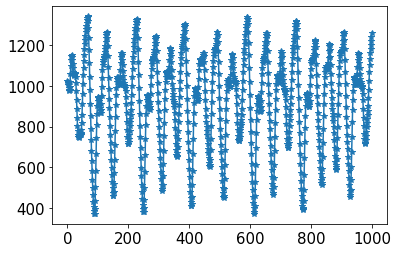

In [12]:
plt.plot(y,  '-*');

In [13]:
n_predict = 200
n_testper = 1  
n_valid = 100

In [14]:
start_time = time.time()

theta, y_arp = predict_optimize_ARp(y,n_predict, n_valid,n_testper,ps=range(1,200,2))

print("--- predict_optimize_ARp took: %s seconds ---" % (time.time() - start_time))

--- predict_optimize_ARp took: 6640.326953172684 seconds ---


In [15]:
start_time = time.time()

rf, y_rf = optimize_predict_rf(y, n_predict,look_back=80)

print("---optimize_predict_rf took: %s seconds ---" % (time.time() - start_time))

---optimize_predict_rf took: 32.93757700920105 seconds ---


In [16]:
start_time = time.time()

lstm, params, y_lstm = predict_optimize_LSTM(y,n_predict, n_valid,n_testper, 
                                              windows=range(20,30,1), lstmsizes=range(1,4),
                                              trainepochs=30, testepochs=40)

print("--- predict_optimize_LSTM took: %s seconds ---" % (time.time() - start_time))

--- predict_optimize_LSTM took: 984.4776163101196 seconds ---


In [17]:
start_time = time.time()

las, y_las = optimize_predict_ridge(y, n_predict,look_back=80)

print("--- optimize_predict_ridge took: %s seconds ---" % (time.time() - start_time))

--- optimize_predict_ridge took: 0.937551736831665 seconds ---


In [18]:
start_time = time.time()

rdg, y_rdg = optimize_predict_lasso(y, n_predict,look_back=80)

print("--- optimize_predict_lasso took: %s seconds ---" % (time.time() - start_time))

--- optimize_predict_lasso took: 4.4690916538238525 seconds ---


In [19]:
rmse_y= np.array([np.sqrt(np.sum((x-y[-n_predict:])**2)) for x in [y_arp,y_arp,y_lstm,y_rdg,y_las]])
print (rmse_y)

[4.43895727e+02 4.43895727e+02 6.12698945e+04 4.71825778e+01
 2.46513110e+01]


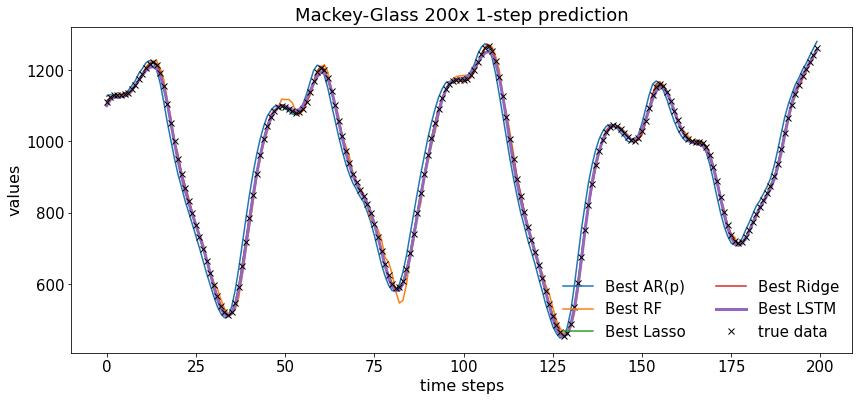

In [20]:
fig = plt.figure(figsize=(14,6))
plt.plot(y_arp,label='Best AR(p)')
plt.plot(y_rf,label='Best RF')
plt.plot(y_las,label='Best Lasso') #[np.argmin(rmses)],label='1-step y_pred')
plt.plot(y_rdg,label='Best Ridge') #[np.argmin(rmses)],label='1-step y_pred')
plt.plot(y_lstm,label='Best LSTM',lw=3)
plt.plot(y[-n_predict:],'kx',label='true data')
plt.xlabel("time steps", fontsize=16)
plt.ylabel("values", fontsize=16)
plt.legend(ncol=2, frameon=False)
plt.title('Mackey-Glass 200x 1-step prediction')
fig.savefig('Mck_1step.pdf',bbox_inches='tight')